# Imports & Configuration

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# Metrics
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

# Visualization & Data Handling
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Configuration
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DATA_DIR = '/kaggle/input/plantvillage-dataset/color'
BATCH_SIZE = 32
NUM_CLASSES = 38

# Data 

In [2]:
# 2. Transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# 3. Initialize the Dataset (This fixes the NameError)
full_dataset = datasets.ImageFolder(DATA_DIR, transform=transform)


# 5. Updated Split: 70% Train, 15% Val, 15% Test
train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_data, val_data, test_data = random_split(full_dataset, [train_size, val_size, test_size])

# 6. Create Loaders
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f"Data Split Success:")
print(f"Train: {len(train_data)} | Val: {len(val_data)} | Test: {len(test_data)}")
print(f"Total Classes: {len(full_dataset.classes)}")

Data Split Success:
Train: 38013 | Val: 8145 | Test: 8147
Total Classes: 38


# Model

In [3]:
class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size=kernel_size, padding=kernel_size//2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Channel-wise max and average to find spatial "hotspots"
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        res = torch.cat([avg_out, max_out], dim=1)
        res = self.conv(res)
        return x * self.sigmoid(res)

class PlantCRNN(nn.Module):
    def __init__(self, num_classes=38, hidden_size=256, dropout=0.4):
        super(PlantCRNN, self).__init__()
        
        # 1. Your Suggested CNN Backbone
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32), nn.ReLU(), nn.MaxPool2d(2, 2), # 128x128
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2, 2), # 64x64
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128), nn.ReLU(), nn.MaxPool2d(2, 2), # 32x32
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128), nn.ReLU(), nn.MaxPool2d(2, 2)  # 16x16
        )
        
        # 2. Spatial Attention
        self.attention = SpatialAttention()
        
        # 3. Bi-LSTM Processor (128 channels * 16 width = 2048 input size)
        self.lstm = nn.LSTM(input_size=128*16, hidden_size=hidden_size, 
                            num_layers=2, batch_first=True, 
                            bidirectional=True, dropout=dropout)
        
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size * 2, num_classes)

    def forward(self, x):
        # Extract features: [B, 128, 16, 16]
        x = self.feature_extractor(x)
        x = self.attention(x)
        
        # Reshape for LSTM: [B, Height, Channels * Width]
        batch_size = x.size(0)
        x = x.permute(0, 2, 1, 3) # [B, 16, 128, 16]
        x = x.reshape(batch_size, 16, -1) # [B, 16, 2048]
        
        # LSTM & Dropout
        lstm_out, _ = self.lstm(x)
        out = self.fc(self.dropout(lstm_out[:, -1, :]))
        return out

model = PlantCRNN(num_classes=NUM_CLASSES).to(DEVICE)

# Structure

In [4]:
print(model)

PlantCRNN(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_st

In [5]:
# Define the Loss Function (with Label Smoothing)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# Define the Optimizer (This fixes your NameError)
# Weight Decay is added here for regularization
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)

# Define the Scheduler
# This helps the model converge better by dropping the LR when accuracy plateaus
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2, factor=0.5)

print("Optimizer, Criterion, and Scheduler are now defined and ready.")

Optimizer, Criterion, and Scheduler are now defined and ready.


# History

In [6]:
# Updated history dictionary to include F1 scores
history = {
    'train_loss': [], 'train_acc': [], 'train_f1': [],
    'val_loss': [], 'val_acc': [], 'val_f1': []
}

EPOCHS = 25 # Set back to 10 or more for actual training

for epoch in range(EPOCHS):
    # --- TRAINING PHASE ---
    model.train()
    train_loss, t_preds, t_labels = 0.0, [], []
    
    for images, labels in train_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        
        # Collect predictions for training metrics
        preds = torch.argmax(outputs, dim=1)
        t_preds.extend(preds.cpu().numpy())
        t_labels.extend(labels.cpu().numpy())
    
    # Calculate Training Metrics
    t_acc = accuracy_score(t_labels, t_preds)
    t_f1 = f1_score(t_labels, t_preds, average='macro')

    # --- VALIDATION PHASE ---
    model.eval()
    val_loss, v_preds, v_labels = 0.0, [], []
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            
            val_loss += criterion(outputs, labels).item()
            
            preds = torch.argmax(outputs, dim=1)
            v_preds.extend(preds.cpu().numpy())
            v_labels.extend(labels.cpu().numpy())
    
    # Calculate Validation Metrics
    v_acc = accuracy_score(v_labels, v_preds)
    v_f1 = f1_score(v_labels, v_preds, average='macro')
    
    # Update Scheduler
    scheduler.step(v_acc)
    
    # Save to History
    history['train_loss'].append(train_loss/len(train_loader))
    history['train_acc'].append(t_acc)
    history['train_f1'].append(t_f1)
    history['val_loss'].append(val_loss/len(val_loader))
    history['val_acc'].append(v_acc)
    history['val_f1'].append(v_f1)
    
    # Professional Print Statement
    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"TRAIN -> Loss: {history['train_loss'][-1]:.4f} | Acc: {t_acc:.4f} | F1: {t_f1:.4f}")
    print(f"VAL   -> Loss: {history['val_loss'][-1]:.4f} | Acc: {v_acc:.4f} | F1: {v_f1:.4f}")
    print("-" * 50)

Epoch 1/25
TRAIN -> Loss: 1.6823 | Acc: 0.6607 | F1: 0.5422
VAL   -> Loss: 1.1769 | Acc: 0.8285 | F1: 0.7538
--------------------------------------------------
Epoch 2/25
TRAIN -> Loss: 1.1309 | Acc: 0.8504 | F1: 0.7846
VAL   -> Loss: 1.0024 | Acc: 0.8918 | F1: 0.8448
--------------------------------------------------
Epoch 3/25
TRAIN -> Loss: 1.0002 | Acc: 0.8953 | F1: 0.8540
VAL   -> Loss: 0.9351 | Acc: 0.9090 | F1: 0.8785
--------------------------------------------------
Epoch 4/25
TRAIN -> Loss: 0.9443 | Acc: 0.9150 | F1: 0.8842
VAL   -> Loss: 0.8759 | Acc: 0.9326 | F1: 0.9059
--------------------------------------------------
Epoch 5/25
TRAIN -> Loss: 0.9003 | Acc: 0.9300 | F1: 0.9057
VAL   -> Loss: 0.8469 | Acc: 0.9408 | F1: 0.9203
--------------------------------------------------
Epoch 6/25
TRAIN -> Loss: 0.8663 | Acc: 0.9418 | F1: 0.9206
VAL   -> Loss: 0.8238 | Acc: 0.9478 | F1: 0.9272
--------------------------------------------------
Epoch 7/25
TRAIN -> Loss: 0.8559 | Acc: 

# Plots

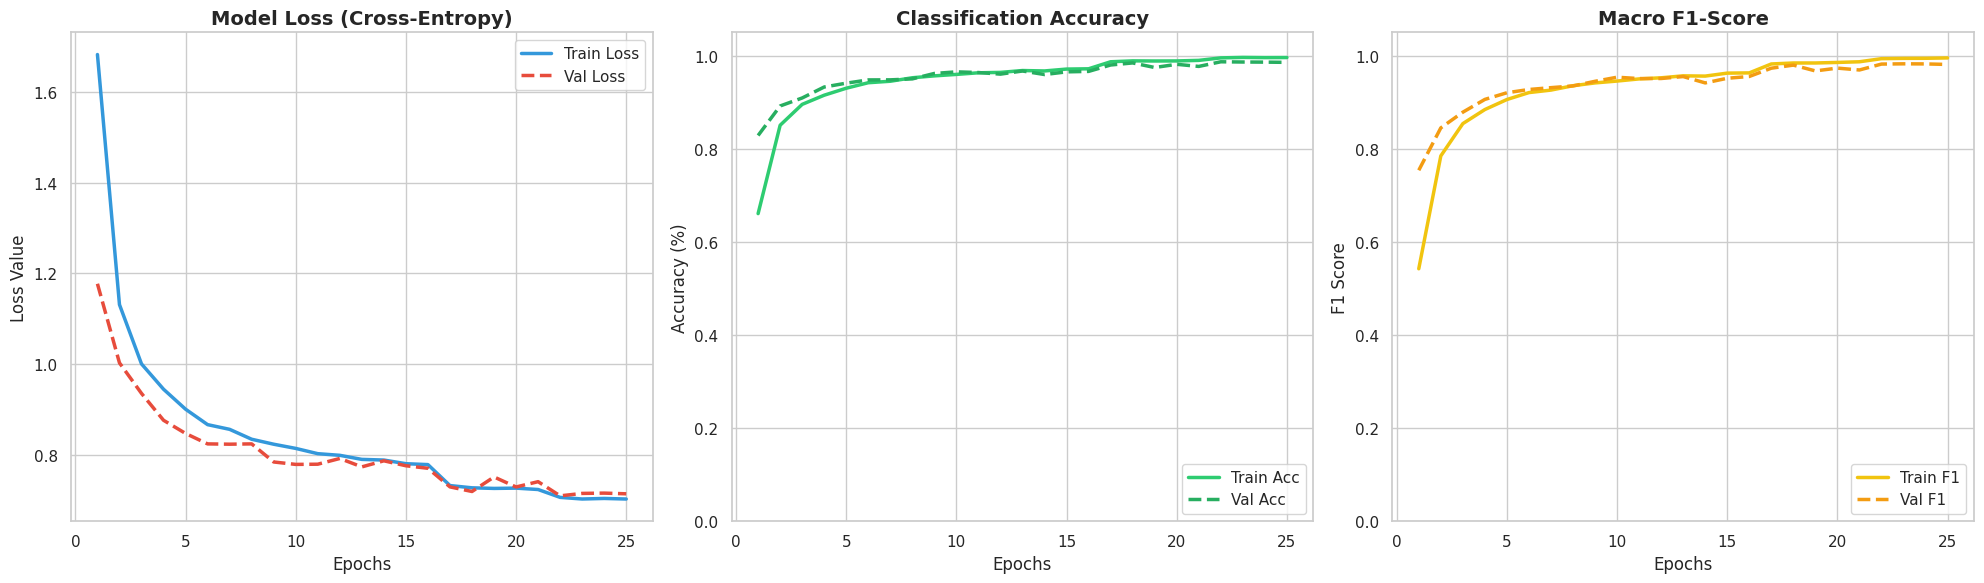

In [7]:
def plot_project_metrics(history):
    # Set a clean, professional aesthetic
    sns.set_theme(style="whitegrid")
    epochs = range(1, len(history['train_loss']) + 1)
    
    # Create 3 subplots in a single row
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

    # --- Plot 1: Loss (Training vs Validation) ---
    ax1.plot(epochs, history['train_loss'], label='Train Loss', color='#3498db', linewidth=2.5)
    ax1.plot(epochs, history['val_loss'], label='Val Loss', color='#e74c3c', linestyle='--', linewidth=2.5)
    ax1.set_title('Model Loss (Cross-Entropy)', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss Value')
    ax1.legend()

    # --- Plot 2: Accuracy (Training vs Validation) ---
    ax2.plot(epochs, history['train_acc'], label='Train Acc', color='#2ecc71', linewidth=2.5)
    ax2.plot(epochs, history['val_acc'], label='Val Acc', color='#27ae60', linestyle='--', linewidth=2.5)
    ax2.set_title('Classification Accuracy', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_ylim([0, 1.05])
    ax2.legend(loc='lower right')

    # --- Plot 3: F1-Score (Training vs Validation) ---
    ax3.plot(epochs, history['train_f1'], label='Train F1', color='#f1c40f', linewidth=2.5)
    ax3.plot(epochs, history['val_f1'], label='Val F1', color='#f39c12', linestyle='--', linewidth=2.5)
    ax3.set_title('Macro F1-Score', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('F1 Score')
    ax3.set_ylim([0, 1.05])
    ax3.legend(loc='lower right')

    plt.tight_layout()
    
    # Save as high-res PNG for your report
    plt.savefig('crnn_performance_plots.png', dpi=300)
    plt.show()

# Run the visualization
plot_project_metrics(history)

# Testing

In [8]:
def perform_final_test(model, loader, classes):
    model.eval()
    y_true, y_pred = [], []
    
    print("Starting Final Inference on Test Set...")
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(DEVICE)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            
            y_pred.extend(preds.cpu().numpy())
            y_true.extend(labels.numpy())

    # 1. Calculate Core Metrics
    test_acc = accuracy_score(y_true, y_pred)
    test_f1 = f1_score(y_true, y_pred, average='macro')
    
    print("\n" + "="*45)
    print(f" FINAL TEST ACCURACY: {test_acc*100:.2f}%")
    print(f" FINAL TEST F1-SCORE: {test_f1:.4f}")
    print("="*45)
    
    # 2. Detailed Classification Report
    print("\nDetailed Performance by Class:")
    print(classification_report(y_true, y_pred, target_names=classes))
    
    return y_true, y_pred

# Run the evaluation
test_labels, test_preds = perform_final_test(model, test_loader, full_dataset.classes)

Starting Final Inference on Test Set...

 FINAL TEST ACCURACY: 98.59%
 FINAL TEST F1-SCORE: 0.9813

Detailed Performance by Class:
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.98      0.99      0.98        93
                                 Apple___Black_rot       0.98      0.99      0.98        93
                          Apple___Cedar_apple_rust       1.00      0.95      0.98        42
                                   Apple___healthy       0.98      0.98      0.98       254
                               Blueberry___healthy       0.99      0.99      0.99       222
          Cherry_(including_sour)___Powdery_mildew       0.98      0.99      0.99       163
                 Cherry_(including_sour)___healthy       1.00      1.00      1.00       131
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.95      0.81      0.88        74
                       Corn_(maize)___Co

# Confusion Matrix

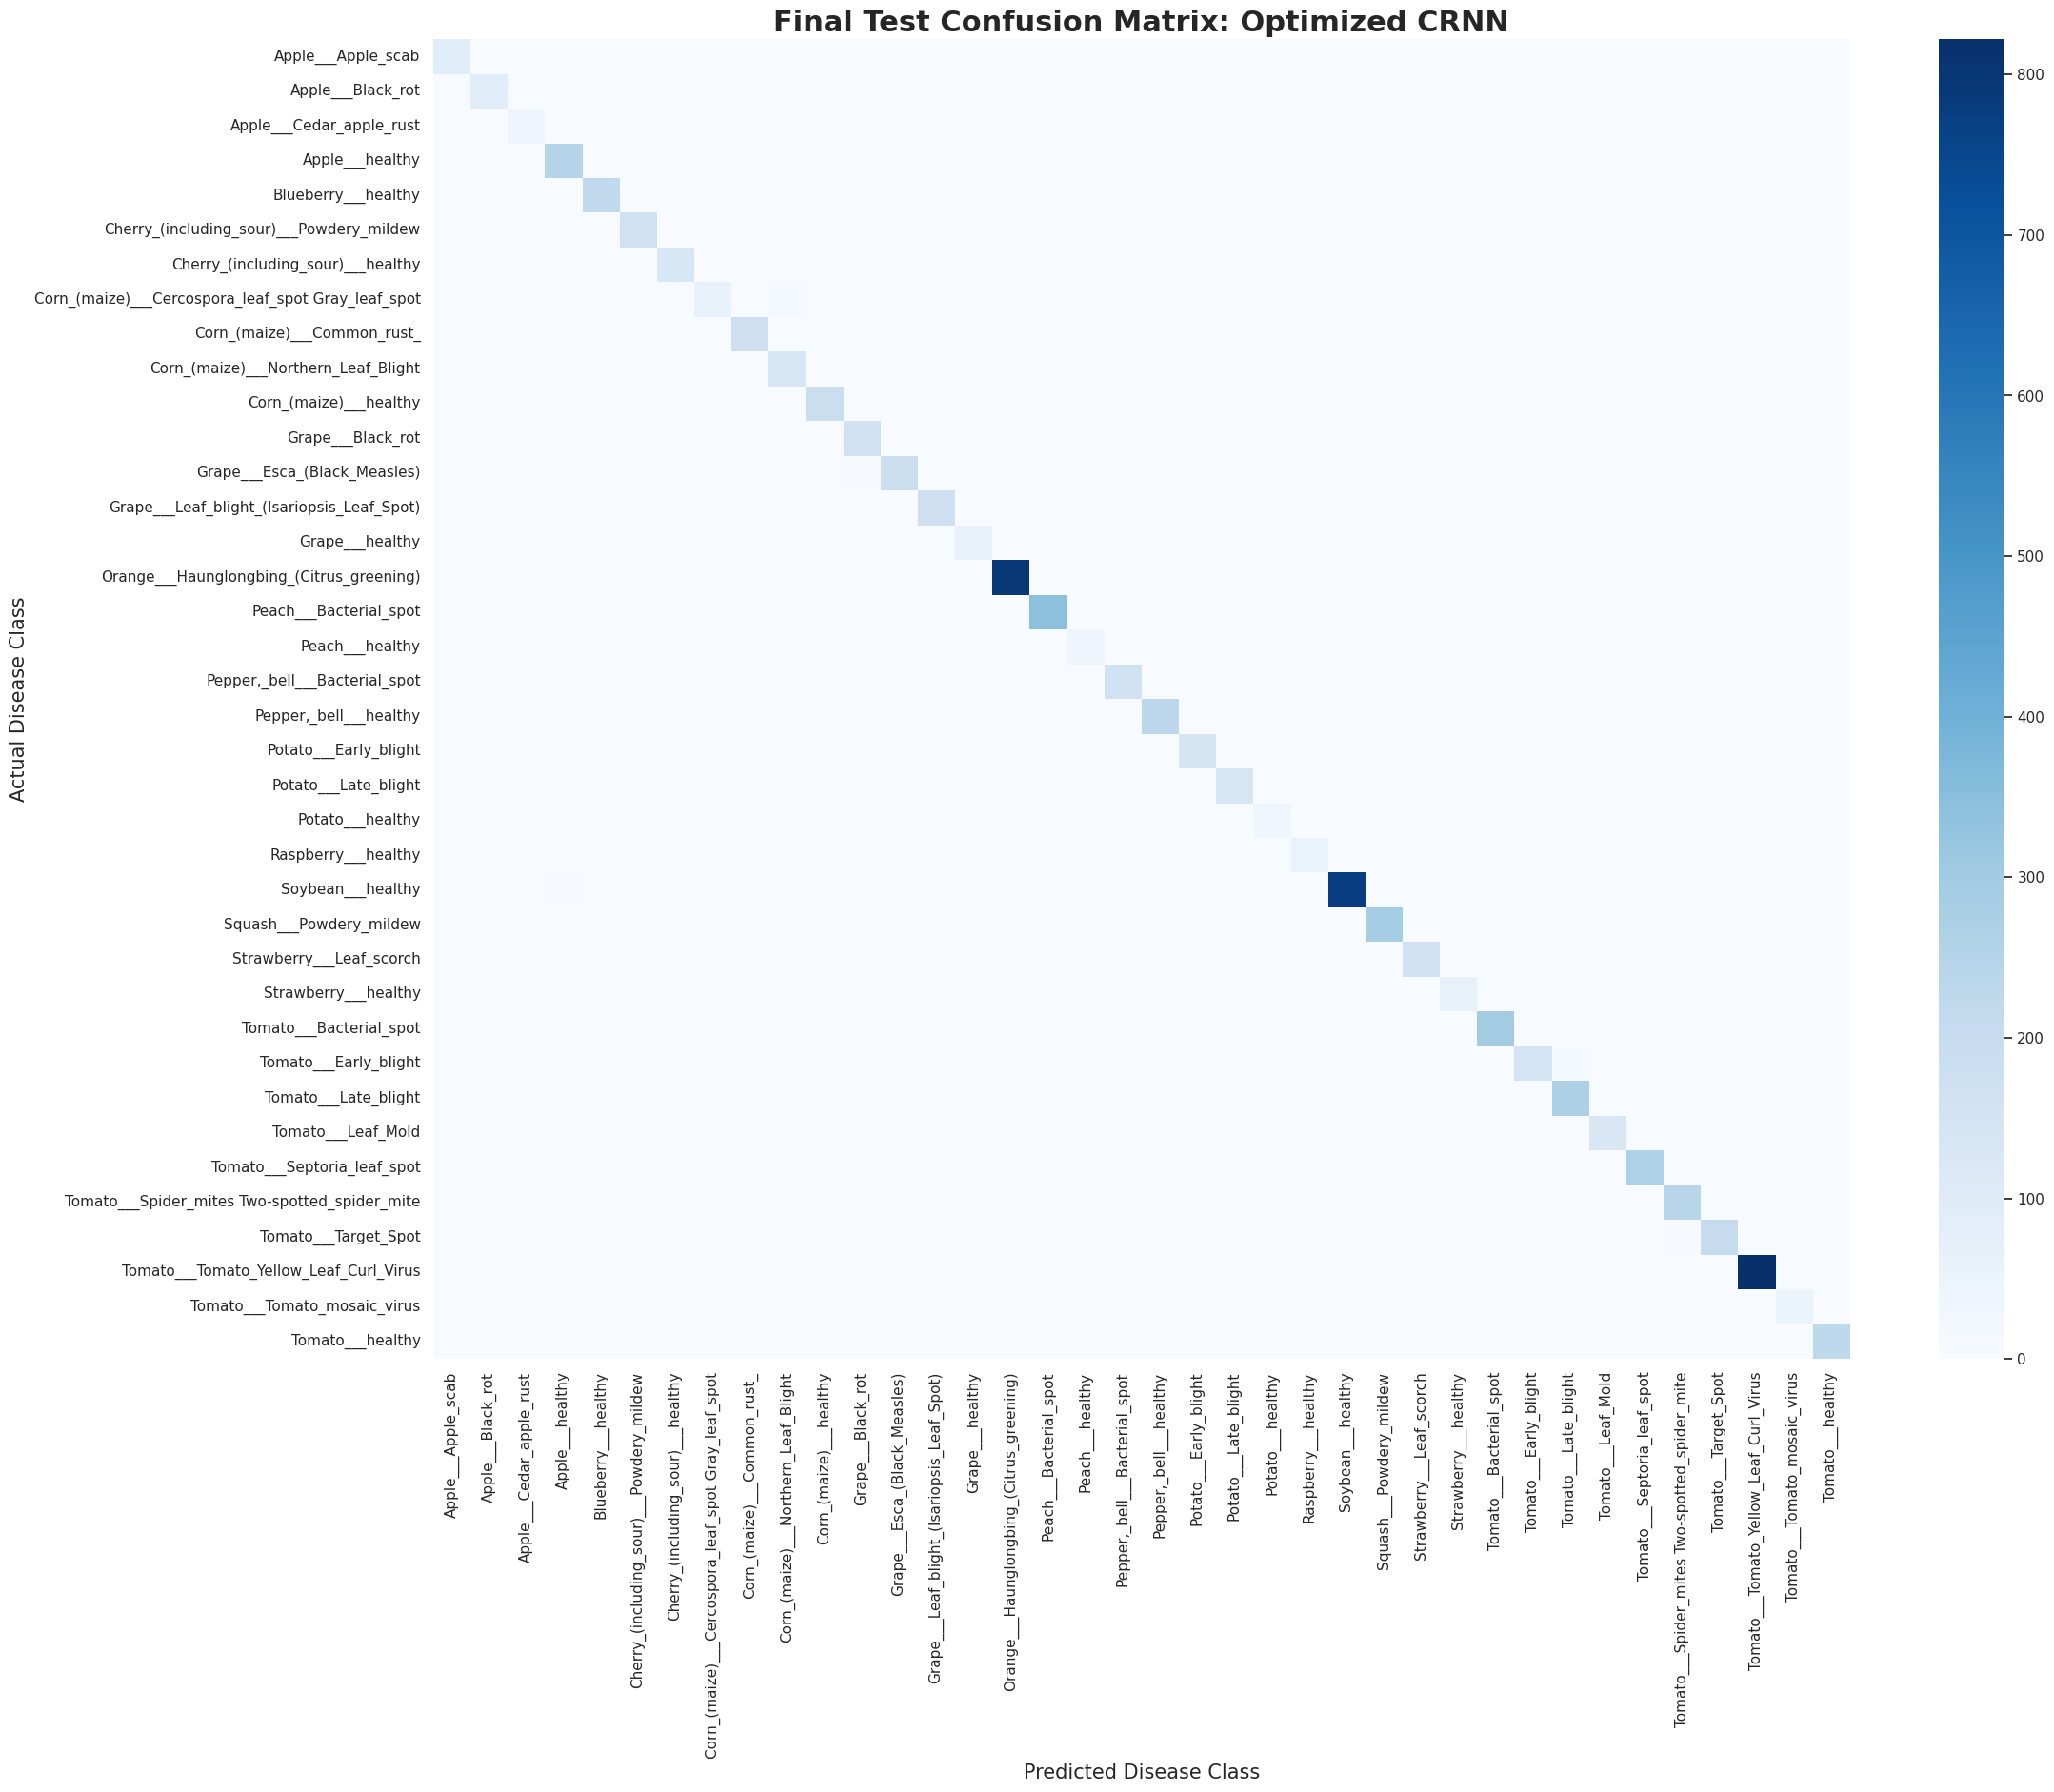

In [9]:
def plot_test_cm(y_true, y_pred, classes):
    # Create the matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Set up the figure (extra large for 38 classes)
    plt.figure(figsize=(24, 18))
    
    # Use Seaborn to plot
    sns.heatmap(cm, 
                annot=False, # Set to True if you want to see raw numbers
                fmt='d', 
                cmap='Blues', 
                xticklabels=classes, 
                yticklabels=classes)
    
    plt.title('Final Test Confusion Matrix: Optimized CRNN', fontsize=22, fontweight='bold')
    plt.xlabel('Predicted Disease Class', fontsize=15)
    plt.ylabel('Actual Disease Class', fontsize=15)
    
    # Save the chart for your final report
    plt.savefig('final_test_confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()

# Run the heatmap
plot_test_cm(test_labels, test_preds, full_dataset.classes)